In [1]:
import mylib
import seaborn as sns
from bs4 import BeautifulSoup as bs
sns.set(rc={'figure.figsize': [10, 10]}, font_scale=1.2)
import pandas as pd
import mylib as mlb

# Cleaning

In [2]:
df=mylib.Describe.describeDf('../DataSet/Data_Train.xlsx')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None
              Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000


In [3]:
arw=df['Route'].unique()[1][4]
df['Route']=df['Route'].apply(  lambda x : ('/'.join([i for i in x.split(arw)]).replace(" ", "")if(type(x)!=float) else'') )

In [4]:
df = df.dropna()
df=df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR/DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU/IXR/BBI/BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL/LKO/BOM/COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU/NAG/BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR/NAG/DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10457,Air Asia,9/04/2019,Kolkata,Banglore,CCU/BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10458,Air India,27/04/2019,Kolkata,Banglore,CCU/BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10459,Jet Airways,27/04/2019,Banglore,Delhi,BLR/DEL,08:20,11:20,3h,non-stop,No info,7229
10460,Vistara,01/03/2019,Banglore,New Delhi,BLR/DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [5]:
def x(z):
        z = z.split(" ")
        if len(z) == 1:
                return int(z[0][:-1]) * 60
        else:
                return (int(z[0][:-1]) * 60) + int(z[1][:-1])


df['Duration'] = df['Duration'].apply(x)
df['Total_Stops'] = df['Total_Stops'].fillna('non-stop')
df['Total_Stops'] = df['Total_Stops'].apply(lambda x: x[0] if x[0] != 'n' else 0)

In [6]:
df['Additional_Info'].replace("No Info",'No info',inplace=True)
df['Additional_Info'].value_counts()

No info                         8185
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [7]:
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])

/home/xcrown/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '24/03/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/xcrown/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '24/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/xcrown/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '27/05/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/xcrown/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18/04/2019' in DD/MM/YYYY 

# Feature_Extraction

In [8]:
df['Day_of_Journey']=df['Date_of_Journey'].dt.day
df['Month_of_Journey']=df['Date_of_Journey'].dt.month
df['Season_of_Journey']=df['Month_of_Journey']%12 // 3 +1

In [9]:
from joblib import load
pagesrc = load('../DataSet/Routs_objects.h5')
Distance = {}
for i in pagesrc:
        soup = bs(i, 'html.parser')
        value = soup.find('span', class_='value km')
        index = soup.find('a', class_='main-route trip')
        if value is None and index is None:
                continue
        Distance.update({index['href'][1:]: ''.join([i for i in value.text if i != ','])})
df['Distance'] = df['Route'].map(Distance)
df['Distance'] = df['Distance'].astype(float)

# OUTLIERs

In [10]:
x=df[df['Additional_Info'].isin(["1 Long layover","Change airports","Red-eye flight"])].index
df.drop(x,inplace=True)

In [11]:
x=df[df['Airline'].isin([k  for k,i  in df['Airline'].value_counts().iteritems() if i <100])].index
df.drop(x,inplace=True)

In [12]:
df['Route'].value_counts()

DEL/BOM/COK        2362
BLR/DEL            1533
CCU/BOM/BLR         979
CCU/BLR             724
BOM/HYD             621
                   ... 
CCU/RPR/HYD/BLR       1
CCU/IXZ/MAA/BLR       1
CCU/VTZ/BLR           1
BOM/CCU/HYD           1
BOM/BBI/HYD           1
Name: Route, Length: 126, dtype: int64

In [13]:
x=df[df['Route'].isin([k  for k,i  in df['Route'].value_counts().iteritems() if i <10])].index
df.drop(x,inplace=True)

In [14]:
mylib.Manipulation.outliers(df,['Distance','Price','Duration'],True)

890


# EDA

<AxesSubplot:xlabel='Additional_Info'>

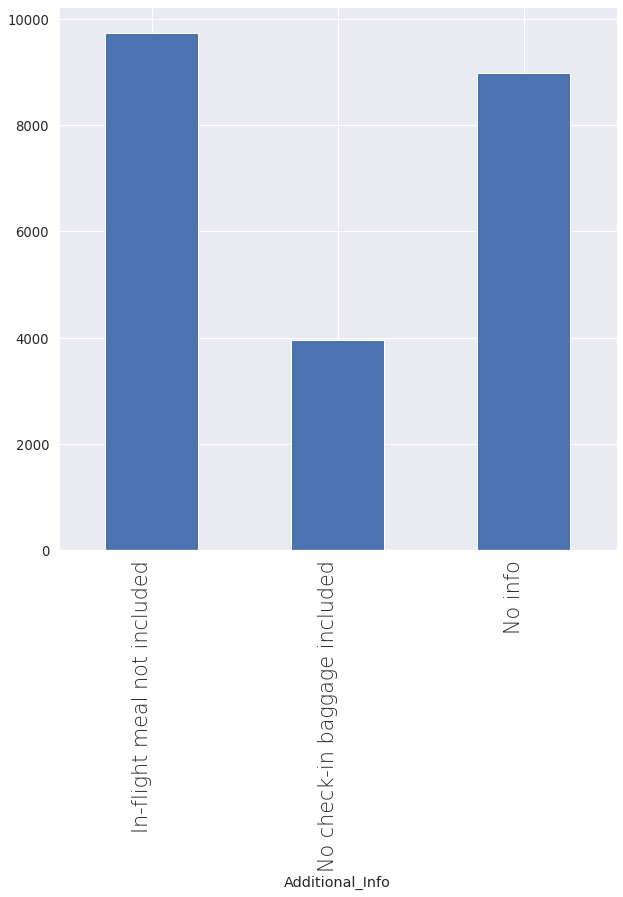

In [15]:
mlb.Visualization.inc_plt()
x=df.groupby(df['Additional_Info']).mean()
x['Price'].plot(kind='bar')

In [16]:
df.drop(['Date_of_Journey','Source','Destination','Dep_Time','Arrival_Time'],inplace=True,axis=1)

In [17]:
df

,Airline,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Season_of_Journey,Distance
0,IndiGo,BLR/DEL,170,0,No info,3897,24,3,2,1710.05
2,Jet Airways,DEL/LKO/BOM/COK,1140,2,No info,13882,6,9,4,2670.87
5,SpiceJet,CCU/BLR,145,0,No info,3873,24,6,3,1546.84
6,Jet Airways,BLR/BOM/DEL,930,1,In-flight meal not included,11087,3,12,1,1972.40
7,Jet Airways,BLR/BOM/DEL,1265,1,No info,22270,3,1,1,1972.40
...,...,...,...,...,...,...,...,...,...,...
10457,Air Asia,CCU/BLR,150,0,No info,4107,4,9,4,1546.84
10458,Air India,CCU/BLR,155,0,No info,4145,27,4,2,1546.84
10459,Jet Airways,BLR/DEL,180,0,No info,7229,27,4,2,1710.05
10460,Vistara,BLR/DEL,160,0,No info,12648,3,1,1,1710.05


<AxesSubplot:xlabel='Additional_Info', ylabel='Price'>

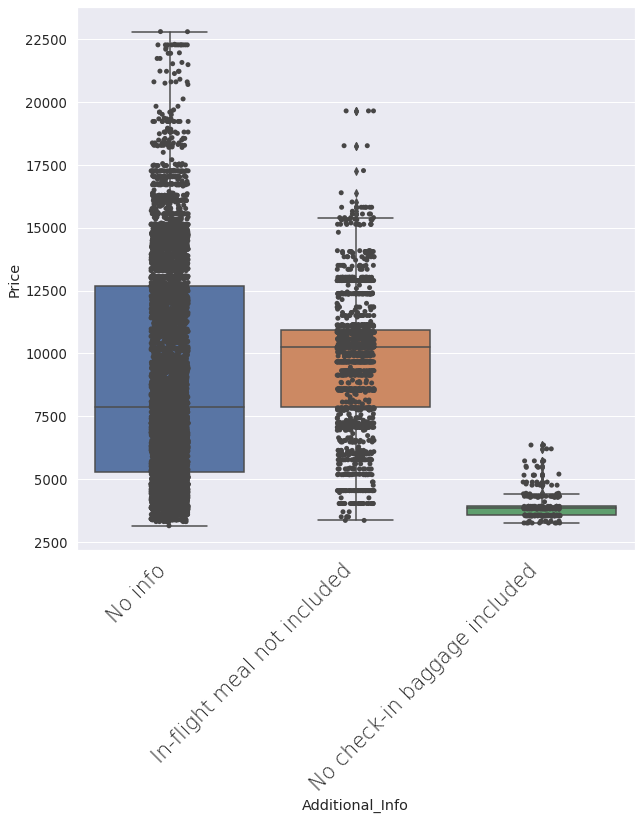

In [18]:
mlb.Visualization.inc_plt()
sns.boxplot(x="Additional_Info", y="Price", data=df)
sns.stripplot(x="Additional_Info", y="Price", color="#474646", size=5, data=df)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9289 entries, 0 to 10461
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Airline            9289 non-null   object 
 1   Route              9289 non-null   object 
 2   Duration           9289 non-null   int64  
 3   Total_Stops        9289 non-null   object 
 4   Additional_Info    9289 non-null   object 
 5   Price              9289 non-null   int64  
 6   Day_of_Journey     9289 non-null   int64  
 7   Month_of_Journey   9289 non-null   int64  
 8   Season_of_Journey  9289 non-null   int64  
 9   Distance           9289 non-null   float64
dtypes: float64(1), int64(5), object(4)
memory usage: 798.3+ KB


<AxesSubplot:xlabel='Month_of_Journey'>

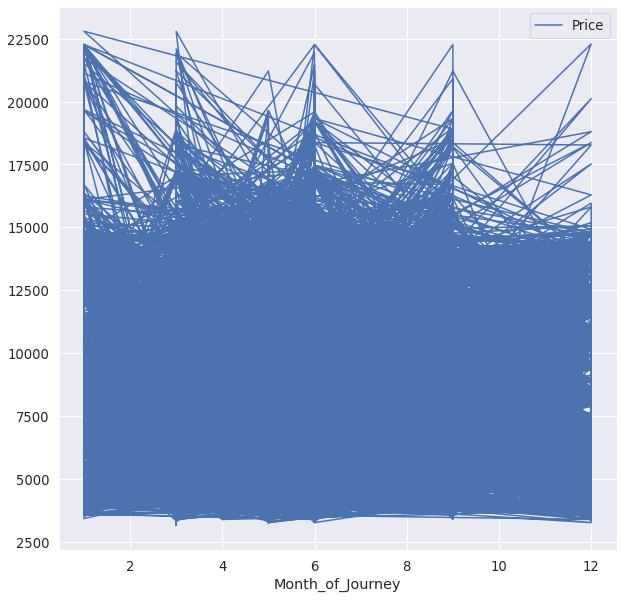

In [20]:
df.plot(x='Month_of_Journey',y='Price')

In [22]:
df

,Airline,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Season_of_Journey,Distance
0,IndiGo,BLR/DEL,170,0,No info,3897,24,3,2,1710.05
2,Jet Airways,DEL/LKO/BOM/COK,1140,2,No info,13882,6,9,4,2670.87
5,SpiceJet,CCU/BLR,145,0,No info,3873,24,6,3,1546.84
6,Jet Airways,BLR/BOM/DEL,930,1,In-flight meal not included,11087,3,12,1,1972.40
7,Jet Airways,BLR/BOM/DEL,1265,1,No info,22270,3,1,1,1972.40
...,...,...,...,...,...,...,...,...,...,...
10457,Air Asia,CCU/BLR,150,0,No info,4107,4,9,4,1546.84
10458,Air India,CCU/BLR,155,0,No info,4145,27,4,2,1546.84
10459,Jet Airways,BLR/DEL,180,0,No info,7229,27,4,2,1710.05
10460,Vistara,BLR/DEL,160,0,No info,12648,3,1,1,1710.05


In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import numpy as np
label_encoder = LabelEncoder()
df['Additional_Info']= label_encoder.fit_transform(df['Additional_Info'])
y,X=df['Price'],df.drop(['Price'],axis=1)
print(x)
col_transform = ColumnTransformer(transformers=[('cat', OneHotEncoder(), ['Airline','Route']),
                                                # ('le',LabelEncoder(),['Additional_Info']),
                                               ('mx',MinMaxScaler(),['Distance','Duration'])]
                                               , remainder='passthrough')
# model= RandomForestRegressor()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,error_score='raise')
scores = np.absolute(scores)
print('MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

                                Duration        Price  Day_of_Journey  \
Additional_Info                                                         
In-flight meal not included   867.354248  9741.474181       13.092726   
No check-in baggage included  159.375000  3957.553030       15.041667   
No info                       593.790836  8986.302741       12.620293   

                              Month_of_Journey  Season_of_Journey     Distance  
Additional_Info                                                                 
In-flight meal not included           5.843976           2.330372  2270.687951  
No check-in baggage included          5.064394           2.287879  1592.617576  
No info                               5.577935           2.330426  2102.341699  


/home/xcrown/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/xcrown/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/xcrown/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/xcrown/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index 

MAE: 674.655 (30.123)
